# Invert three surveys line for a thin plate

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_three_lines_transmitters.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/airborne_em

In [3]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cofi

from forward_lib import (
    problem_setup, 
    system_spec, 
    survey_setup, 
    ForwardWrapper, 
    plot_predicted_profile, 
    plot_transient, 
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

# Background

This example inverts a three survey line of VTEM max data using the vertical  component for a thin plate target. It thus becomes possible to invert for the easting,northing, depth of the palte reference point, the plate dip and plate azimuth and the plate length.

## Problem definition

In [4]:
tx_min = 115
tx_max = 281
tx_interval = 15
ty_min = 25
ty_max = 176
ty_interval = 75
tx_points = numpy.arange(tx_min, tx_max, tx_interval)
ty_points = numpy.arange(ty_min, ty_max, ty_interval)
n_transmitters = len(tx_points) * len(ty_points)
tx, ty = numpy.meshgrid(tx_points, ty_points)
tx = tx.flatten()
ty = ty.flatten()

In [5]:
fiducial_id = numpy.arange(len(tx))
line_id = numpy.zeros(len(tx), dtype=int)
line_id[ty==ty_points[0]] = 0
line_id[ty==ty_points[1]] = 1
line_id[ty==ty_points[2]] = 2

In [6]:
survey_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": ty,                                                   # transmitter northing/y-position
    "tz": numpy.array([50]*n_transmitters),                     # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_transmitters)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_transmitters)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": numpy.array([100]*n_transmitters),                    # receiver northing/y-position
    "rz": numpy.array([50]*n_transmitters),                     # receiver height/z-position
    "trdx": numpy.array([0]*n_transmitters),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_transmitters),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_transmitters),                    # transmitter receiver separation vertical
    "fiducial_id": fiducial_id,                                 # unique id for each transmitter
    "line_id": line_id                  # id for each line
}

In [7]:
true_model = {
    "res": numpy.array([300, 1000]), 
    "thk": numpy.array([20]), 
    "peast": numpy.array([175]), 
    "pnorth": numpy.array([100]), 
    "ptop": numpy.array([30]), 
    "pres": numpy.array([0.1]), 
    "plngth1": numpy.array([100]), 
    "plngth2": numpy.array([100]), 
    "pwdth1": numpy.array([0.1]), 
    "pwdth2": numpy.array([90]), 
    "pdzm": numpy.array([75]),
    "pdip": numpy.array([60])
}

In [8]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup,
                         ["pdip","pdzm", "peast", "ptop", "pwdth2"], data_returned=["vertical"])

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']


In [9]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']

In [10]:
true_param_value = numpy.array([60,65, 175, 30, 90])

**Generate synthetic data**

In [11]:
# The data 
absolute_noise= 0.05

# create data and ad a realisation of the noise
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.randn(len(data_pred_true))*absolute_noise

# define data covariance matrix
sigma=absolute_noise
Cdinv=numpy.identity(len(data_obs))*(1.0/(sigma*sigma))

## Paraemter Estimation

**Initialise a model for inversion**

In [12]:
init_param_value = numpy.array([45, 90, 150, 20, 80])

**Define helper functions for inversion**

In [13]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ Cdinv @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model, relative_step=0.1)
    residual = dpred - data_obs
    return jacobian.T @ Cdinv @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return jacobian.T @ Cdinv @ jacobian

class PerIterationCallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

**Define CoFI problem**

In [14]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

**Define CoFI options**

In [15]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG",callback=PerIterationCallbackFunction())

**Define CoFI inversion**

In [16]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

Iteration #1
  objective value: 28156.090971234113
Iteration #2
  objective value: 7945.748122074432
Iteration #3
  objective value: 3305.913874192912
Iteration #4
  objective value: 2005.277336381015
Iteration #5
  objective value: 1789.9038341784058
Iteration #6
  objective value: 1586.161737421272
Iteration #7
  objective value: 1580.4298687756632
Iteration #8
  objective value: 1576.0083558129834
Iteration #9
  objective value: 1575.8042546510237
Iteration #10
  objective value: 1574.174504161134
Iteration #11
  objective value: 1574.0818435232331
Iteration #12
  objective value: 1567.7243125261489
Iteration #13
  objective value: 1564.8785962197378
Iteration #14
  objective value: 1562.7466785098757
[ 59.97937675  65.25637629 174.87679042  30.0069352   90.16170003]


## Plotting

**Plotting the data**

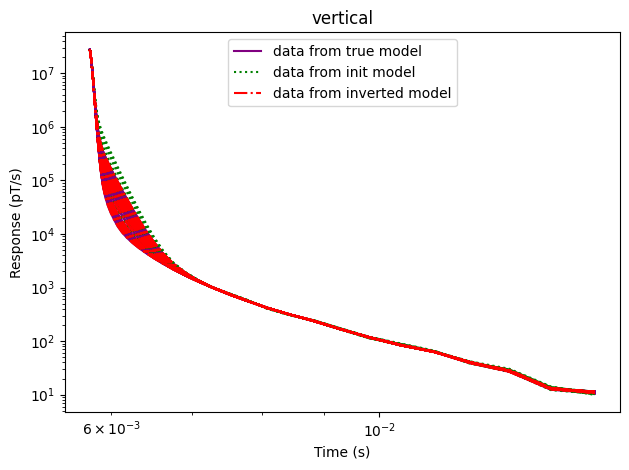

In [17]:
_, ax = plt.subplots()
plot_transient(true_param_value, forward, "data from true model", ax, color="purple")
plot_transient(init_param_value, forward, "data from init model", ax, color="green", linestyle=":")
plot_transient(my_result.model, forward, "data from inverted model", ax, color="red", linestyle="-.")
ax.legend(loc="upper center")
ax.set_title("vertical")
plt.tight_layout()

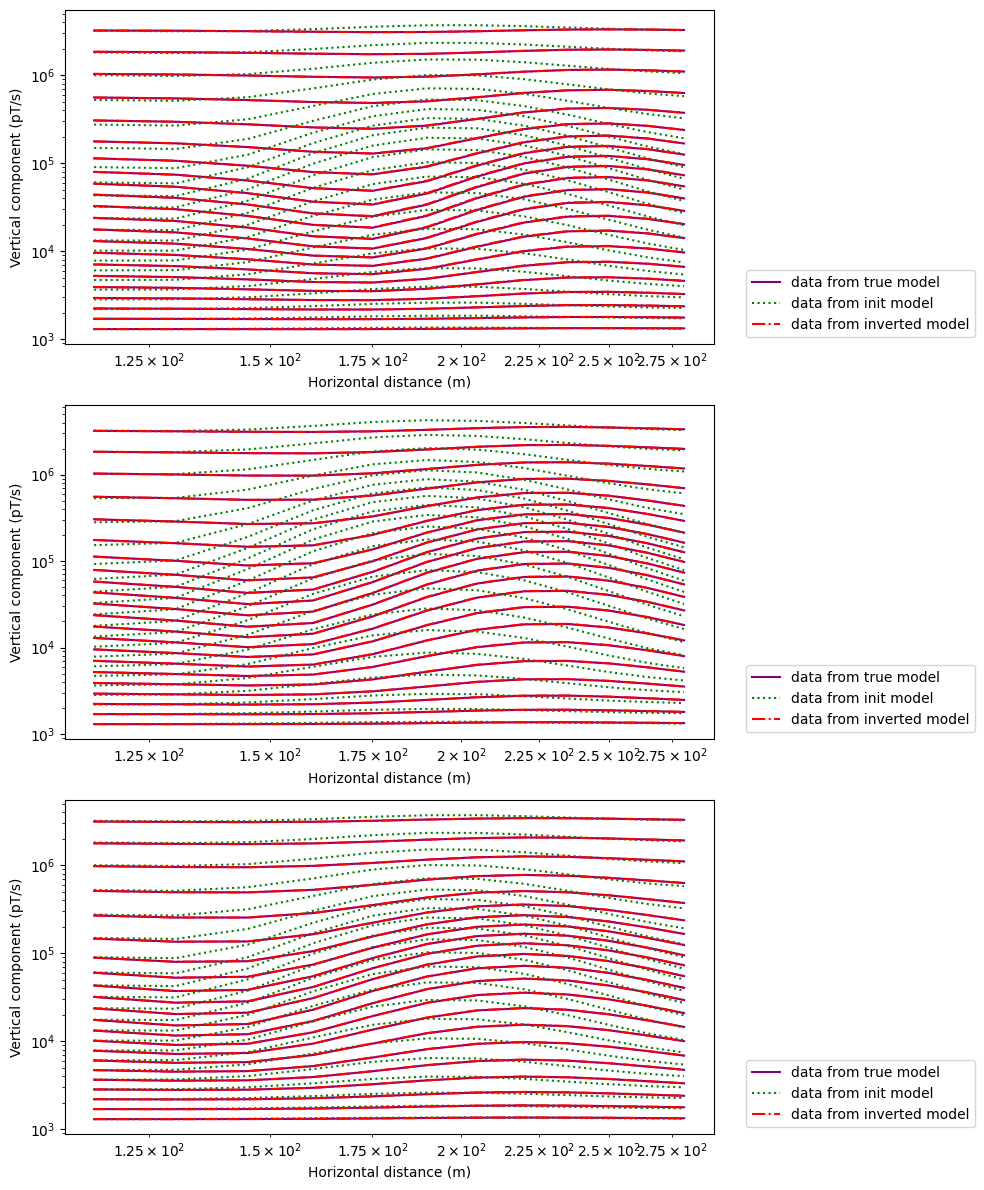

In [22]:
idx_to_plot = numpy.arange(8, 30)       # (0, 44)

_, axes = plt.subplots(3, 1, figsize=(10,12))

for i in range(3):
    plot_predicted_profile(true_param_value, forward, "data from true model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="purple")
    plot_predicted_profile(init_param_value, forward, "data from init model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="green", linestyle=":")
    plot_predicted_profile(my_result.model, forward, "data from inverted model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="red", linestyle="-.")
    axes[i].legend(bbox_to_anchor=(1.04, 0), loc="lower left")
plt.tight_layout()

**Plotting the model**

 As a general rule we can only constrain parateters if there are fiducials in the survey that are ssnsitvit tothem and also fiducials that are not sensitive to them. In order words the anomly needs to be closed with respect to the model paratmeter in question. So to be able to constraint plate lenghy we would need survey lines to the north and south that are not overflying the thin plate.

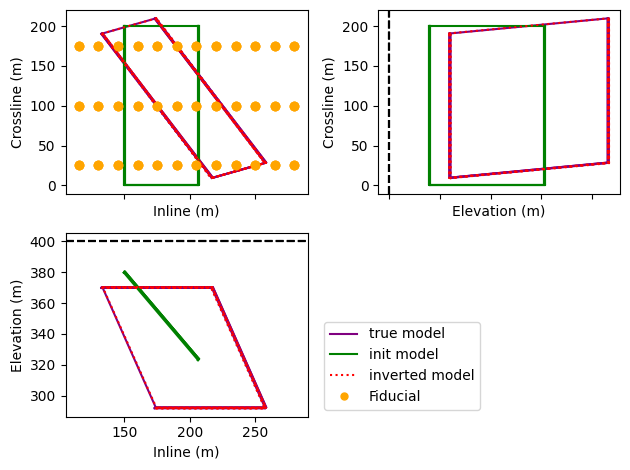

In [19]:
_, axes = plt.subplots(2, 2, sharex="col")
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="true model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="init model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="inverted model", linestyle="dotted"
)

plt.tight_layout()

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

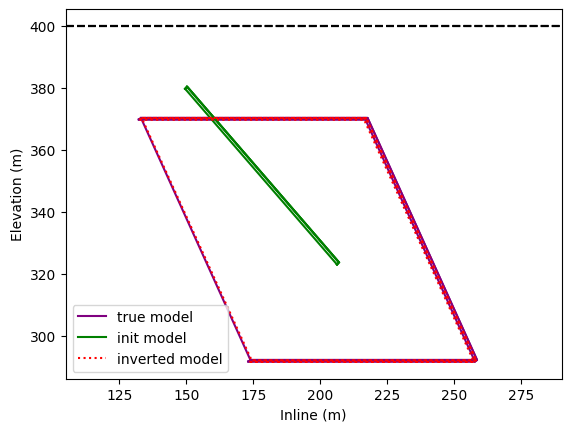

In [20]:
_, ax = plt.subplots(1, 1)
plot_plate_faces_single("plate_true", "xz", forward, true_param_value, ax, color="purple", label="true model")
plot_plate_faces_single("plate_init", "xz", forward, init_param_value, ax, color="green", label="init model")
plot_plate_faces_single("plate_inverted", "xz", forward, my_result.model, ax, color="red", label="inverted model", linestyle="dotted")
ax.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [21]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib","smt"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.0.1
scipy 1.14.0
matplotlib 3.9.1.post1
smt 2.6.3
